In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import keras_tuner as kt

# Modelo
# Cargar dataset
df = pd.read_csv('../datasetintermedio.csv')
df_not_outliers = df.drop(columns=['es_outlier'])

# Separar X e y
y = df['Precio_usd']
X = df.drop(columns=['Precio_usd'])

X_sin_outliers = df_not_outliers.drop(columns=['Precio_usd'])

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_scaled_sin_outliers = scaler.fit_transform(X_sin_outliers)

# Split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Split sin outliers
X_train_sin_outliers, X_test_sin_outliers, y_train_sin_outliers, y_test_sin_outliers = train_test_split(
    X_scaled_sin_outliers, y, test_size=0.2, random_state=42
)


In [32]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner2.search(X_train, y_train, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model2 = tuner2.get_best_models(num_models=1)[0]

Trial 10 Complete [00h 01m 16s]
val_mae: 16481.490234375

Best val_mae So Far: 4141.48291015625
Total elapsed time: 00h 14m 20s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [13]:
# Modelo
def build_model2(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train_sin_outliers.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner2 = kt.RandomSearch(
    build_model2,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar mejores hiperparámetros
tuner2.search(
    X_train_sin_outliers, y_train_sin_outliers,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    verbose=1
)

# Mejor modelo
best_model_sinOutlier = tuner2.get_best_models(num_models=1)[0]

Trial 3 Complete [00h 01m 12s]
val_mae: 4434.76025390625

Best val_mae So Far: 4408.28955078125
Total elapsed time: 00h 03m 37s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
256               |160               |units_1
0.3               |0.4               |dropout_1
48                |128               |units_2
0.2               |0.4               |dropout_2
32                |32                |units_3
0.01              |0.01              |lr



c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 23058.0176 - mae: 23054.2734 - val_loss: 6819.4878 - val_mae: 6804.9194
Epoch 2/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 8047.7666 - mae: 8032.2866 - val_loss: 6176.2295 - val_mae: 6158.9429
Epoch 3/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 7504.0874 - mae: 7486.1108 - val_loss: 5823.9604 - val_mae: 5804.3862
Epoch 4/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 6757.3931 - mae: 6737.2930 - val_loss: 5745.4863 - val_mae: 5723.9053
Epoch 5/50
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 6896.6167 - mae: 6874.4883 - val_loss: 5794.2217 - val_mae: 5770.4937
Epoch 6/50
 35/366 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 6196.0708 - mae: 6172.3086

KeyboardInterrupt: 

In [ ]:
history = best_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, verbose=1)
history_sin_Outliers = best_model_sinOutlier.fit(X_train_sin_outliers, y_train_sin_outliers, validation_split=0.2, epochs=100, batch_size=32, verbose=1)


Epoch 1/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 1s 954us/step - loss: 4829.3467 - mae: 4699.3115 - val_loss: 4581.5840 - val_mae: 4452.6377
Epoch 2/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 4665.1094 - mae: 4535.9312 - val_loss: 4290.1851 - val_mae: 4160.0166
Epoch 3/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 751us/step - loss: 4623.1577 - mae: 4492.5708 - val_loss: 4350.4478 - val_mae: 4218.9409
Epoch 4/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 737us/step - loss: 4632.2544 - mae: 4500.1543 - val_loss: 4394.9170 - val_mae: 4262.0132
Epoch 5/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 801us/step - loss: 4648.8555 - mae: 4515.6875 - val_loss: 4307.5820 - val_mae: 4173.3267
Epoch 6/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 738us/step - loss: 4496.9414 - mae: 4362.4600 - val_loss: 4033.4602 - val_mae: 3898.2930
Epoch 7/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 741us/step - loss: 4622.5059 - mae: 4487.2100 - val_loss: 4424.8779 - val_mae: 4288.8403
Epoch 8/100
366/366 ━━━━━━━━━━━━━━━━━━━━ 0s 740us/step - loss: 4638.3

In [ ]:
y_pred = best_model.predict(X_test).flatten()

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / y_test)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


y_pred_sin_outliers = best_model_sinOutlier.predict(X_test_sin_outliers).flatten()
mae_sin_outliers = mean_absolute_error(y_test_sin_outliers, y_pred_sin_outliers)
rmse_sin_outliers = np.sqrt(mean_squared_error(y_test_sin_outliers, y_pred_sin_outliers))
r2_sin_outliers = r2_score(y_test_sin_outliers, y_pred_sin_outliers)
mape_sin_outliers = np.mean(np.abs((y_test_sin_outliers - y_pred_sin_outliers) / y_test_sin_outliers)) * 100
print(f"\n--- MÉTRICAS SIN OUTLIERS ---")
print(f"MAE: ${mae_sin_outliers:,.0f}")
print(f"RMSE: ${rmse_sin_outliers:,.0f}")
print(f"R2: {r2_sin_outliers:.3f}")
print(f"MAPE: {mape_sin_outliers:.2f}%")

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 524us/step

--- MÉTRICAS ---
MAE: $4,107
RMSE: $9,789
R2: 0.784
MAPE: 42.86%
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 496us/step

--- MÉTRICAS SIN OUTLIERS ---
MAE: $4,101
RMSE: $10,141
R2: 0.768
MAPE: 39.52%


In [ ]:
# Asumiendo que ya tenés y_test (valores reales) y y_pred (predicciones del modelo)
df_resultados = pd.DataFrame({
    'Precio_real': y_test,
    'Precio_predicho': y_pred
})

# Error absoluto
df_resultados['Error_absoluto'] = np.abs(df_resultados['Precio_real'] - df_resultados['Precio_predicho'])

# Crear segmentos (cuartiles) por precio real
df_resultados['Segmento_precio'] = pd.qcut(df_resultados['Precio_real'], q=4, labels=['Bajo', 'Medio-bajo', 'Medio-alto', 'Alto'])

# Calcular métricas por segmento
resumen_segmentos = df_resultados.groupby('Segmento_precio').agg({
    'Precio_real': ['count', 'mean'],
    'Error_absoluto': ['mean', 'median', 'max']
}).round(0)

# Mostrar resumen
print(resumen_segmentos)

                Precio_real          Error_absoluto                  
                      count     mean           mean  median       max
Segmento_precio                                                      
Bajo                    924  12905.0         2675.0  1572.0  104128.0
Medio-bajo              908  20183.0         2520.0  1714.0   26130.0
Medio-alto              906  28109.0         2857.0  2247.0   56083.0
Alto                    913  51609.0         8374.0  4098.0  208459.0


/var/folders/h8/075vvj7s65sgq5xnd_m0zfkc0000gn/T/ipykernel_78580/3629614219.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  resumen_segmentos = df_resultados.groupby('Segmento_precio').agg({


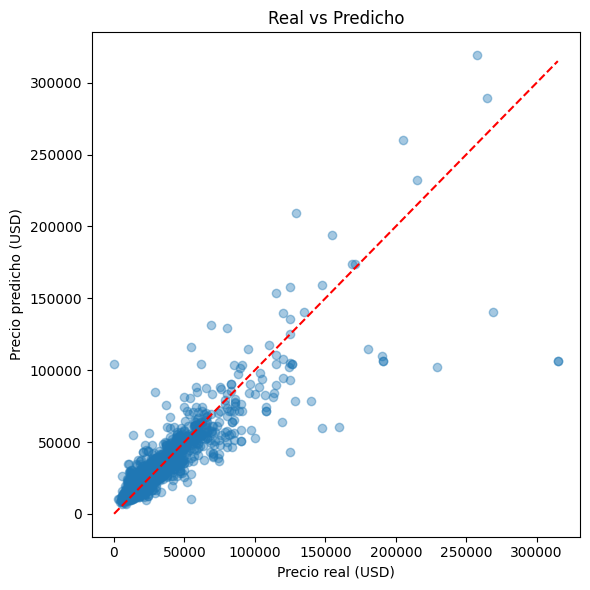

In [ ]:
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], '--', color='red')
plt.xlabel("Precio real (USD)")
plt.ylabel("Precio predicho (USD)")
plt.title("Real vs Predicho")
plt.tight_layout()
plt.show()

In [14]:
dataset1 = pd.read_csv('../dataset_basico.csv')

X1, y1 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X1)

# Split
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y1, test_size=0.2, random_state=42)


In [ ]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train1.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train1, y_train1, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 12s]
val_mae: 4065.701904296875

Best val_mae So Far: 3101.319580078125
Total elapsed time: 00h 11m 00s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [16]:
y_pred = best_model.predict(X_test1).flatten()

mae = mean_absolute_error(y_test1, y_pred)
rmse = np.sqrt(mean_squared_error(y_test1, y_pred))
r2 = r2_score(y_test1, y_pred)
mape = np.mean(np.abs((y_test1 - y_pred) / y_test1)) * 100

print(f"\n--- MÉTRICAS ---")
print(f"MAE: ${mae:,.0f}")
print(f"RMSE: ${rmse:,.0f}")
print(f"R2: {r2:.3f}")
print(f"MAPE: {mape:.2f}%")


104/104 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

--- MÉTRICAS ---
MAE: $3,029
RMSE: $4,668
R2: 0.807
MAPE: 12.80%


In [ ]:
# Recuperar los mejores hiperparámetros
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model1 = build_model(best_hp)
history1 = model1.fit(
    X_train1, y_train1,
    validation_data=(X_test1, y_test1),
    epochs=50,
    batch_size=32,
    verbose=1
)



c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 16360.1006 - mae: 16353.5293 - val_loss: 3803.7332 - val_mae: 3788.6353
Epoch 2/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5615.8638 - mae: 5600.0459 - val_loss: 3920.9375 - val_mae: 3904.2039
Epoch 3/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 5041.0391 - mae: 5023.3403 - val_loss: 3541.6438 - val_mae: 3522.9407
Epoch 4/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - loss: 4611.0942 - mae: 4591.8984 - val_loss: 3379.3816 - val_mae: 3359.2202
Epoch 5/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4479.0259 - mae: 4458.7251 - val_loss: 3352.0752 - val_mae: 3331.5835
Epoch 6/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4377.2832 - mae: 4356.7261 - val_loss: 3321.2380 - val_mae: 3300.8325
Epoch 7/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4323.6665 - mae: 4303.0747 - val_loss: 3394.6602 - val_mae: 3374.1770
Epoch 8/50
413/413 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4211.2256 - mae: 4190.5605 -

In [33]:
# Recuperar los mejores hiperparámetros
best_hp2 = tuner2.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model2 = build_model(best_hp2)
history2 = model2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


457/457 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 27668.1504 - mae: 27667.7656 - val_loss: 26622.0352 - val_mae: 26620.7480
Epoch 2/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 24534.1250 - mae: 24532.1406 - val_loss: 16945.9551 - val_mae: 16941.1699
Epoch 3/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 15254.9404 - mae: 15249.1455 - val_loss: 10235.3223 - val_mae: 10226.8477
Epoch 4/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 9760.9404 - mae: 9751.7832 - val_loss: 6906.2876 - val_mae: 6895.4565
Epoch 5/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7849.5332 - mae: 7838.4478 - val_loss: 5941.6631 - val_mae: 5930.0952
Epoch 6/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7397.2642 - mae: 7385.5601 - val_loss: 5871.5737 - val_mae: 5859.5630
Epoch 7/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7528.0239 - mae: 7515.9512 - val_loss: 5737.0186 - val_mae: 5724.7896
Epoch 8/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 7431.8477 - mae: 7419.5581 - 

In [39]:
dataset1 = pd.read_csv('../dataset_final.csv')

X2, y2 = dataset1.drop(columns='Precio_usd'), dataset1['Precio_usd']

# Escalar con MinMax
scaler = MinMaxScaler()
X_scaled2 = scaler.fit_transform(X2)

# Split
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_scaled2, y2, test_size=0.2, random_state=42)


In [40]:
# Modelo
def build_model(hp):
    model = Sequential()
    model.add(Dense(
        units=hp.Int('units_1', 64, 256, step=32),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001),
        input_shape=(X_train2.shape[1],)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_1', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_2', 32, 128, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))
    model.add(BatchNormalization())
    model.add(Dropout(rate=hp.Float('dropout_2', 0.2, 0.5, step=0.1)))

    model.add(Dense(
        units=hp.Int('units_3', 16, 64, step=16),
        activation='relu',
        kernel_regularizer=regularizers.l2(0.001)
    ))

    model.add(Dense(1, activation='linear'))

    model.compile(
        optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
        loss='mae',
        metrics=['mae']
    )
    return model

# Tuner
tuner = kt.RandomSearch(
    build_model,
    objective='val_mae',
    max_trials=10,
    executions_per_trial=1,
    overwrite=True,
    directory='tuning_mlp',
    project_name='auto_price'
)

# Buscar
tuner.search(X_train2, y_train2, validation_split=0.2, epochs=50, batch_size=32, verbose=1)

# Mejor modelo
best_model = tuner.get_best_models(num_models=1)[0]


Trial 10 Complete [00h 01m 20s]
val_mae: 16126.849609375

Best val_mae So Far: 968.4190063476562
Total elapsed time: 00h 12m 06s


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\saving\saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [41]:
# Recuperar los mejores hiperparámetros
best_hp3 = tuner.get_best_hyperparameters(num_trials=1)[0]
# Construir el modelo desde cero con los mejores hiperparámetros
model3 = build_model(best_hp3)
history3 = model3.fit(
    X_train2, y_train2,
    validation_data=(X_test2, y_test2),
    epochs=50,
    batch_size=32,
    verbose=1
)

Epoch 1/50


c:\Users\andyd\miniconda3\envs\myenv\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


457/457 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 18499.7988 - mae: 18491.8223 - val_loss: 4085.8608 - val_mae: 4066.4924
Epoch 2/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6458.2651 - mae: 6438.2476 - val_loss: 3606.4329 - val_mae: 3584.5261
Epoch 3/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5587.6729 - mae: 5565.4165 - val_loss: 3311.6733 - val_mae: 3288.1519
Epoch 4/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 5248.2593 - mae: 5224.4438 - val_loss: 3169.5139 - val_mae: 3144.5183
Epoch 5/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4792.6494 - mae: 4767.6802 - val_loss: 3519.1736 - val_mae: 3493.6316
Epoch 6/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4869.0073 - mae: 4843.3828 - val_loss: 2132.3081 - val_mae: 2106.7861
Epoch 7/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4433.6147 - mae: 4407.8105 - val_loss: 1990.2504 - val_mae: 1964.1376
Epoch 8/50
457/457 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 4420.1875 - mae: 4394.1265 - val_loss: 

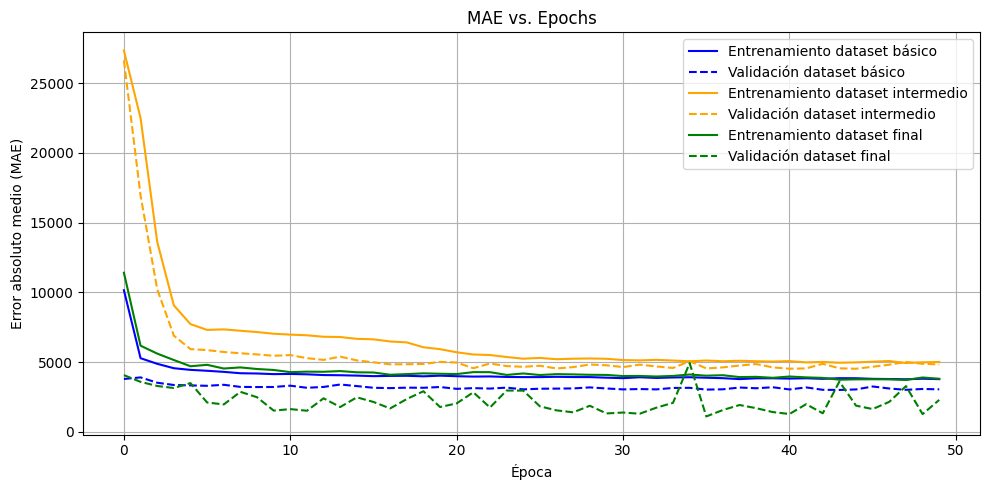

In [42]:

plt.figure(figsize=(10, 5))
plt.plot(history1.history['mae'], label='Entrenamiento dataset básico',color='blue')
plt.plot(history1.history['val_mae'], label='Validación dataset básico',color='blue', linestyle='--')
plt.plot(history2.history['mae'], label='Entrenamiento dataset intermedio',color='orange')
plt.plot(history2.history['val_mae'], label='Validación dataset intermedio', linestyle='--', color='orange')
plt.plot(history3.history['mae'], label='Entrenamiento dataset final',color='green')
plt.plot(history3.history['val_mae'], label='Validación dataset final', linestyle='--', color='green')
plt.title('MAE vs. Epochs')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio (MAE)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
